In [1]:
import os
import numpy as np
import openslide
from openslide.deepzoom import DeepZoomGenerator
from openslide import open_slide, ImageSlide
from PIL import Image
from matplotlib import pyplot as plt
from openslide import OpenSlide
import cv2
import numpy as np
from matplotlib import pyplot as plt
from openslide import OpenSlide

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import pyvips
from torchvision.transforms import ToPILImage

/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [140]:
# --- 1. Load DINO-v2 Backbone ---

def get_dino_v2_backbone():
    # This returns a model directly, not a state_dict
    backbone = torch.hub.load("facebookresearch/dinov2", "dinov2_vitb14")  # ✅ this is already a model
    return backbone


class DINOv2SegmentationModel(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone
        self.num_classes = num_classes
        self.decoder = nn.Sequential(
            nn.Conv2d(768, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        B, C, H, W = x.shape
        features = self.backbone.get_intermediate_layers(x, n=1)[0]  # (B, N, 768)
        feat_size = int(features.shape[1] ** 0.5)
        features = features.permute(0, 2, 1).reshape(B, 768, feat_size, feat_size)  # (B, 768, h, w)
        out = self.decoder(features)  # (B, num_classes, h, w)
        out = F.interpolate(out, size=(H, W), mode='bilinear', align_corners=False)  # upscale to 1022x1022
        return out
    
def make_prediction(image):
    transform = transforms.Compose([
        transforms.Resize((1022, 1022)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    #image = Image.open(img_path).convert("RGB")
    image = image.convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)  # (1, 3, 1022, 1022)
    image_np = np.array(image.convert("RGB").resize((1022, 1022)))
    with torch.no_grad():
        output = model(input_tensor)  # (1, num_classes, 1022, 1022)
        print(output, output.shape)
        #pred_mask = output.argmax(dim=1).squeeze(0).cpu().numpy()  # (1022, 1022)
        probs = torch.softmax(output, dim=1)  # convert logits → probabilities
        conf, pred = torch.max(probs, dim=1)  # conf: confidence per pixel, pred: predicted class
        conf = conf.squeeze(0).cpu().numpy()  # (1022, 1022)
        pred_mask = pred.squeeze(0).cpu().numpy()  # (1022, 1022)
        threshold = 0.99  # choose based on your model's calibration
        high_conf_mask = np.where(conf >= threshold, pred_mask, 0)
        print(high_conf_mask)
        
    mask_rescaled = cv2.resize(high_conf_mask, (512, 512), interpolation=cv2.INTER_NEAREST)
    return image_np, mask_rescaled

In [3]:
def is_background(tile, threshold=0.8):
    """
    Check if a tile is mostly background (white).
    Args:
        tile (PIL.Image): The tile image.
        threshold (float): Fraction of white pixels to consider as background (0.0–1.0).
    Returns:
        bool: True if background, False otherwise.
    """
    img = np.array(tile.convert("L"))  # Convert to grayscale
    white_pixels = np.sum(img > 240)   # Count near-white pixels
    total_pixels = img.size
    white_ratio = white_pixels / total_pixels
    return white_ratio > threshold


def get_bbox(row, col,pred_mask):
    class_ids = np.unique(pred_mask)
    class_ids = class_ids[class_ids != 0]
    pred_boxes = []
    for class_id in class_ids:
        # Create binary mask for this class
        binary = (pred_mask == class_id).astype(np.uint8)

        # Find contours for that class
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        #contours = list(map(lambda t: t[0], sorted([(contour, cv2.contourArea(contour)) for contour in contours], key=lambda t: -t[1])))

        sorted_with_area = sorted([(c, cv2.contourArea(c)) for c in contours], key=lambda x: x[1],reverse=True)
        for contour, area in sorted_with_area:
            if area>5000:
                print(area)
                x, y, w, h = cv2.boundingRect(contour)
                pred_boxes.append([row, col, x, y, w, h])
            #cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 4)
    return pred_boxes


def tile_svs(slide_path, output_dir, tile_size=512, overlap=0, limit_bounds=True, level=0, bg_threshold=0.8):
    """
    Tile a single .svs file into small image patches and save non-background tiles as JPEGs.
    
    Args:
        slide_path (str): Path to the .svs file.
        output_dir (str): Directory to save tiles.
        tile_size (int): Tile size (default=512).
        overlap (int): Overlap between tiles (default=0).
        limit_bounds (bool): Restrict to non-empty region.
        level (int): DeepZoom level to extract tiles from (default=0 = highest resolution).
        bg_threshold (float): Fraction of white pixels above which tile is considered background.
    """
    slide = openslide.open_slide(slide_path)
    dz = DeepZoomGenerator(slide, tile_size=tile_size, overlap=overlap, limit_bounds=limit_bounds)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cols, rows = dz.level_tiles[level]
    print(f"Tiling level {level} with {cols}x{rows} tiles...")

    saved = 0
    skipped = 0
    pred_boxes_all = []

    
    for row in range(rows):
        for col in range(cols):
            tile = dz.get_tile(level, (col, row))
            if is_background(tile, threshold=bg_threshold):
                skipped += 1
                continue
            img, pred_mask = make_prediction(tile)
            pred_boxes = get_bbox(row, col, pred_mask)
            pred_boxes_all.extend(pred_boxes)
            
            tile_path = os.path.join(output_dir, f"tile_{col}_{row}.jpeg")
            tile.save(tile_path, "JPEG")
            #break
            #print(np.array(tile).shape)
            saved += 1
            if saved==1:
                break
        if saved==1:
            break
    print(f"Done! Saved {saved} tiles, skipped {skipped} background tiles.")
    print(f"Tiles saved in: {output_dir}")
    
    df = pd.DataFrame(pred_boxes_all, columns=["row","col","x1","y1","x2","y2"])
    
    return df

In [4]:
path = "/gladstone/finkbeiner/steve/work/data/npsad_data/monika/ALS/dino_v2_segmentation_oct10.pth"
path = "/gladstone/finkbeiner/steve/work/data/npsad_data/monika/ALS/dino_v2_segmentation_oct17.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = get_dino_v2_backbone()
model = DINOv2SegmentationModel(backbone, num_classes=3)  # Update `num_classes` as needed
model.load_state_dict(torch.load(path, map_location=device))
model.to(device)
model.eval()  # 🔍 Important for inference

Using cache found in /home/mahirwar/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available
/tmp/ipykernel_3074650/2352124358.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues

DINOv2SegmentationModel(
  (backbone): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False

In [10]:
slide_path ='/gladstone/finkbeiner/steve/work/data/ALS/fals-lumbar/NEUKM699KKH_Lumbar_pTDP_43.svs'
output_dir = '/gladstone/finkbeiner/steve/work/data/npsad_data/monika/ALS/tiles-npy'          # <-- Output folder
df = tile_svs(
    slide_path,
    output_dir,
    tile_size=512,
    level=18,
    limit_bounds=False,
    bg_threshold=0.7                 # <-- Adjust to 0.7–0.9 depending on your slides
)

Tiling level 18 with 289x153 tiles...
38046.5
10635.5
42510.0
Done! Saved 1 tiles, skipped 16 background tiles.
Tiles saved in: /gladstone/finkbeiner/steve/work/data/npsad_data/monika/ALS/tiles-npy


In [35]:
df.to_csv(os.path.join(output_dir, "NEUKM699KKH_Lumbar_pTDP_43.csv"))

In [36]:
df

,row,col,x1,y1,x2,y2
0,1,16,722,11,183,645
1,1,271,216,936,469,86
2,1,271,965,288,57,211
3,2,16,605,13,417,996
4,2,271,0,135,69,640
...,...,...,...,...,...,...
1527,152,225,0,579,690,443
1528,152,226,0,568,582,454
1529,152,285,544,951,367,61
1530,152,287,0,861,850,143


In [5]:
fname = '/gladstone/finkbeiner/steve/work/data/ALS/fals-lumbar/NEUKM699KKH_Lumbar_pTDP_43.svs'

output_dir = '/gladstone/finkbeiner/steve/work/data/npsad_data/monika/ALS/tiles-npy'

slide = pyvips.Image.new_from_file(fname, level=0)

In [6]:
im = slide.numpy()[..., :3]        

In [8]:
im.shape

(78179, 147560, 3)

In [ ]:
def get_tiles(h, w, size, level):
    """
    Generate a list of tile coordinates for a slide image.
    
    Args:
        h (int): Height of the slide.
        w (int): Width of the slide.
        size (int): Size of each tile.
        level (int): The zoom level of the slide.
        
    Returns:
        list: A list of tuples containing the coordinates of each tile.
    """
    return [(y, x) for x in range(((w * (2 ** level)) // size) + 1) for y in range(((h * (2 ** level)) // size) + 1)]

In [9]:
h, w = im.shape[0],  im.shape[1]
size = 512

In [10]:
t = [(y, x) for x in range((w // size)-1) for y in range((h// size)-1)]

In [11]:
w, h

(147560, 78179)

In [12]:
t[-1]

(150, 286)

In [13]:
len(t)

43337

In [14]:
t[-1]

(150, 286)

In [ ]:
crop = slide.crop(t[-1][1]*512, t[-1][0]*512, 512, 512)

In [ ]:
crop = np.ndarray(
            buffer=crop.write_to_memory(), dtype=np.uint8,
            shape=(crop.width, crop.height, crop.bands))[..., :3]  # Keep only the RGB channels

In [ ]:
crop = ToPILImage()(crop)

In [19]:
def crop_tile(slide, out_dir, tile, ext='png'):
    """
    Crops a portion of the slide based on the specified tile and saves or returns the result.

    Args:
        slide: The slide object (e.g., pyvips.Image) to crop from.
        out_dir (str): Output directory where the cropped tile will be saved (filename will be generated).
        tile (tuple): The coordinates (x, y, width, height) for cropping the slide.
        ext (str): The file extension for the output image (default is 'png').

    Returns:
        tuple: A tuple containing the output filename and the cropped tile data as a numpy array.
    """
    # Generate the output filename based on the tile coordinates and extension
    out_file = out_dir + '/'+'_'.join(map(lambda _: '_'.join(_), zip('xy', map(str, tile[:2])))) + f'.{ext}'
    # Crop the slide using the tile coordinates and convert to numpy array
    #crop = slide.crop(*tile).numpy()
    crop = slide.crop(tile[1]*512, tile[0]*512, tile[2], tile[3])

        # Convert the cropped image to a numpy array
    crop = np.ndarray(
            buffer=crop.write_to_memory(), dtype=np.uint8,
            shape=(crop.height, crop.width, crop.bands))[..., :3]  # Keep only the RGB channels
    # Uncomment to save the cropped tile to the disk
    #ToPILImage()(crop)   #.save(out_file)
    # Return the output filename and the cropped image
    return out_file, crop

In [20]:
def select_crop(slide, output_dir, t, i):
    out_file, crop = crop_tile(slide, output_dir,(t[i][0], t[i][1], 512,512) )
    #crop = ToPILImage(crop)
    bg_flag = is_background(crop, threshold=0.7)
    return bg_flag

In [21]:
def is_background(tile, threshold=0.8):
    """
    Check if a tile is mostly background (white).
    Args:
        tile (PIL.Image): The tile image.
        threshold (float): Fraction of white pixels to consider as background (0.0–1.0).
    Returns:
        bool: True if background, False otherwise.
    """
    #img = np.array(tile.convert("L"))  # Convert to grayscale
    img = np.array(tile)
    white_pixels = np.sum(img > 240)   # Count near-white pixels
    total_pixels = img.size
    white_ratio = white_pixels / total_pixels
    return white_ratio > threshold

In [22]:
for_sel = [select_crop(slide, output_dir, t, i) for i in range(5000)]

In [28]:
false_indices = [i for i in range(len(for_sel)) if for_sel[i]==False]

In [30]:
false_indices

[1213,
 1229,
 1363,
 1497,
 1514,
 1903,
 2052,
 2053,
 2054,
 2055,
 2203,
 2204,
 2205,
 2206,
 2353,
 2354,
 2355,
 2356,
 2357,
 2416,
 2417,
 2418,
 2419,
 2420,
 2421,
 2422,
 2423,
 2424,
 2425,
 2426,
 2427,
 2428,
 2429,
 2430,
 2431,
 2432,
 2433,
 2434,
 2435,
 2505,
 2506,
 2507,
 2568,
 2570,
 2571,
 2572,
 2573,
 2574,
 2575,
 2576,
 2577,
 2578,
 2579,
 2580,
 2581,
 2582,
 2583,
 2584,
 2585,
 2586,
 2587,
 2588,
 2589,
 2590,
 2591,
 2592,
 2593,
 2594,
 2595,
 2596,
 2597,
 2598,
 2599,
 2600,
 2601,
 2602,
 2603,
 2604,
 2605,
 2606,
 2607,
 2608,
 2609,
 2610,
 2611,
 2612,
 2613,
 2614,
 2615,
 2616,
 2617,
 2618,
 2619,
 2620,
 2621,
 2622,
 2623,
 2624,
 2625,
 2626,
 2627,
 2628,
 2629,
 2630,
 2631,
 2765,
 2766,
 2767,
 2768,
 2769,
 2770,
 2771,
 2772,
 2773,
 2774,
 2775,
 2776,
 2777,
 2778,
 2779,
 2780,
 2781,
 2782,
 2783,
 2784,
 2785,
 2786,
 2787,
 2788,
 2789,
 2790,
 2791,
 2792,
 2793,
 2794,
 2795,
 2796,
 2797,
 2798,
 2799,
 2800,
 2801,
 2802,

In [123]:
val = t[false_indices[50]]

In [137]:
val

(10, 17)

In [124]:
crop = slide.crop(val[1]*512, val[0]*512,512,512)

In [125]:
crop

<pyvips.Image 512x512 uchar, 4 bands, srgb>

In [126]:
crop = np.ndarray(
            buffer=crop.write_to_memory(), dtype=np.uint8,
            shape=(crop.height, crop.width, crop.bands))[..., :3]  # Keep only the RGB channels

In [127]:
crp = ToPILImage(crop)

In [128]:
crp = Image.fromarray(crop)

In [129]:
def get_bbox(row, col,pred_mask):
    class_ids = np.unique(pred_mask)
    class_ids = class_ids[class_ids != 0]
    pred_boxes = []
    for class_id in class_ids:
        # Create binary mask for this class
        binary = (pred_mask == class_id).astype(np.uint8)

        # Find contours for that class
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        #contours = list(map(lambda t: t[0], sorted([(contour, cv2.contourArea(contour)) for contour in contours], key=lambda t: -t[1])))

        sorted_with_area = sorted([(c, cv2.contourArea(c)) for c in contours], key=lambda x: x[1],reverse=True)
        for contour, area in sorted_with_area:
            if area>5000:
                print(area)
                x, y, w, h = cv2.boundingRect(contour)
                pred_boxes.append([row, col, x, y, w, h])
            #cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 4)
    return pred_boxes

In [141]:
img, pred_mask = make_prediction(crp)
pred_boxes = get_bbox(8, 5, pred_mask)

tensor([[[[ 4.6517,  4.6517,  4.6517,  ...,  3.0512,  3.0512,  3.0512],
          [ 4.6517,  4.6517,  4.6517,  ...,  3.0512,  3.0512,  3.0512],
          [ 4.6517,  4.6517,  4.6517,  ...,  3.0512,  3.0512,  3.0512],
          ...,
          [ 4.1629,  4.1629,  4.1629,  ...,  4.0203,  4.0203,  4.0203],
          [ 4.1629,  4.1629,  4.1629,  ...,  4.0203,  4.0203,  4.0203],
          [ 4.1629,  4.1629,  4.1629,  ...,  4.0203,  4.0203,  4.0203]],

         [[-5.3782, -5.3782, -5.3782,  ..., -5.0177, -5.0177, -5.0177],
          [-5.3782, -5.3782, -5.3782,  ..., -5.0177, -5.0177, -5.0177],
          [-5.3782, -5.3782, -5.3782,  ..., -5.0177, -5.0177, -5.0177],
          ...,
          [-4.5219, -4.5219, -4.5219,  ..., -4.3875, -4.3875, -4.3875],
          [-4.5219, -4.5219, -4.5219,  ..., -4.3875, -4.3875, -4.3875],
          [-4.5219, -4.5219, -4.5219,  ..., -4.3875, -4.3875, -4.3875]],

         [[-2.1667, -2.1667, -2.1667,  ..., -1.1454, -1.1454, -1.1454],
          [-2.1667, -2.1667, -

In [142]:
pred_boxes

[[8, 5, 48, 0, 51, 512]]

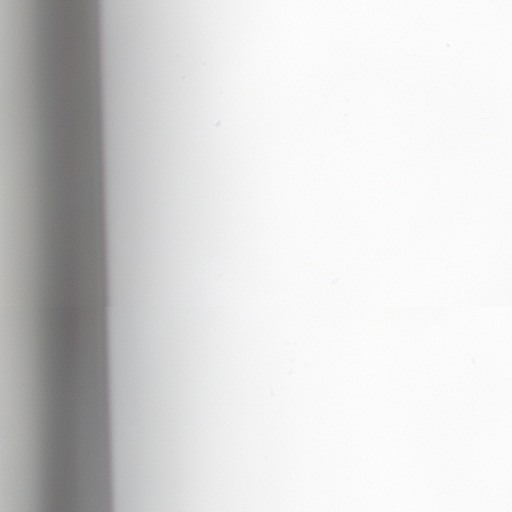

In [143]:
crp

In [132]:
mask_rescaled = cv2.resize(pred_mask, (512, 512), interpolation=cv2.INTER_NEAREST)


In [144]:
np.unique(pred_mask)

array([0, 2], dtype=int32)

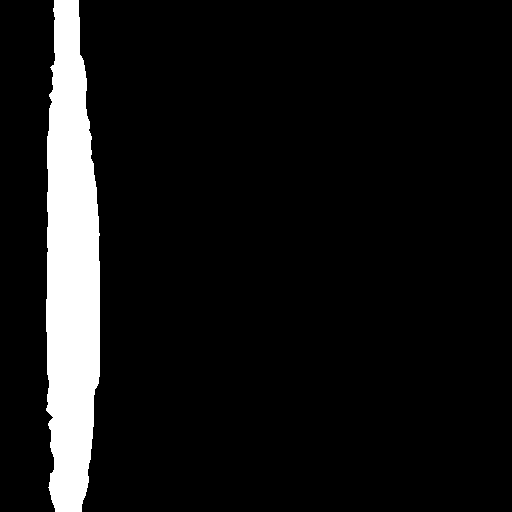

In [135]:
Image.fromarray(pred_mask==2)

In [64]:
pred_mask.shape

(1022, 1022)